In [21]:
import pandas as pd
from common import collect_results, normalize_region_name, compute_quantiles
from pathlib import Path
from matplotlib import pyplot as plt

In [22]:
ROOT = Path("tpcc")

def get_matcher(system):
    def matcher(p: Path):   
        import re
        pattern = re.compile(r"tpcc-\d+-%s-terminals\d+-([\d-]+)" % system)
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        return {
            "suffix": str(match.group(1)),
        }
    
    return matcher

In [23]:
import json

def yb_matcher(p: Path):   
    import re
    pattern = re.compile(r"tpcc-(\d+)-yugabyte-terminals(\d+)")
    match = pattern.match(p.name)
    if not match:
        return None

    print("Found result:", p.name)
    return {
        "scalefactor": int(match.group(1)),
        "terminals": int(match.group(2)),
    }

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def collect_yugabyte_results(path, renew_cache: bool):
    cache = path / "cache.csv"

    if renew_cache:
        cache.unlink(missing_ok=True)

    if cache.is_file():
        return pd.read_csv(cache)

    records = []
    for result_dir in path.iterdir():
        if not result_dir.is_dir():
            continue

        metadata = yb_matcher(result_dir)
        if metadata is None:
            continue

        for region_path in result_dir.iterdir():
            if not region_path.is_dir():
                continue
            record = {"path": region_path.as_posix(), "region": region_path.name, **metadata}

            raw_df = pd.read_csv(region_path / "oltpbench.csv", skiprows=2)
            raw_df["OperationLatency (microseconds)"] /= 1000

            transactions = raw_df["Transaction Name"].unique()
            for transaction in transactions:
                record.update(
                    compute_quantiles(
                        raw_df[raw_df["Transaction Name"] == transaction]["OperationLatency (microseconds)"],
                        remove_lower_outliers=True,
                        remove_upper_outliers=True,
                        suffix=f".{transaction}"
                    )
                )

            record.update(
                compute_quantiles(
                    raw_df["OperationLatency (microseconds)"],
                    remove_lower_outliers=True,
                    remove_upper_outliers=True
                )
            )

            output = json.loads((region_path / "json" / "output.json").read_text())

            runtime = output["TestConfiguration"]["runTimeInSecs"]
            record["time"] = runtime
            record["warmup"] = output["TestConfiguration"]["warmupTimeInSecs"]
            record["throughput"] = output["Results"]["throughput"]
            for lat in output["Latencies"]:
                if lat["Transaction"] != "All":
                    record[f"throughput.{lat['Transaction']}"] = lat["Count"] / runtime

            records.append(record)
    
    df = pd.DataFrame.from_records(records)
    df.to_csv(cache, index=False)

    return df

# Throughput


In [24]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte", "cockroach"]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm-serializable",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"
sunstorm_throughput_df["terminals_rank"] = sunstorm_throughput_df["terminals"].rank(method="dense")
normalize_region_name(sunstorm_throughput_df)

# sunstorm_matcher = get_matcher("sunstorm")
# sunstorm_serializable_throughput_df = collect_results(
#     ROOT / "sunstorm-serializable",
#     sunstorm_matcher,
#     RENEW_CACHE,
# )
# sunstorm_serializable_throughput_df["system"] = "sunstorm-serializable"
# sunstorm_serializable_throughput_df["terminals_rank"] = sunstorm_serializable_throughput_df["terminals"].rank(method="dense")
# normalize_region_name(sunstorm_serializable_throughput_df)


aurora_matcher = get_matcher("aurora")
aurora_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_throughput_df["system"] = "aurora"
aurora_throughput_df["terminals_rank"] = aurora_throughput_df["terminals"].rank(method="dense")
normalize_region_name(aurora_throughput_df)


yugabyte_matcher = get_matcher("yugabyte")
yugabyte_throughput_df = collect_yugabyte_results(ROOT / "yugabyte", RENEW_CACHE)
yugabyte_throughput_df["system"] = "yugabyte"
yugabyte_throughput_df["terminals_rank"] = yugabyte_throughput_df["terminals"].rank(method="dense")
normalize_region_name(yugabyte_throughput_df)

cockroach_matcher = get_matcher("cockroach")
cockroach_throughput_df = collect_results(
    ROOT / "cockroach",
    cockroach_matcher,
    RENEW_CACHE,
)
cockroach_throughput_df["system"] = "cockroach" 
cockroach_throughput_df["terminals_rank"] = cockroach_throughput_df["terminals"].rank(method="dense")
normalize_region_name(cockroach_throughput_df)

In [25]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    #sunstorm_serializable_throughput_df,
    aurora_throughput_df,
    yugabyte_throughput_df,
    cockroach_throughput_df,
])
throughput_df

,path,region,suffix,rejected,rejected.NewOrder,rejected.Payment,rejected.OrderStatus,rejected.Delivery,rejected.StockLevel,aborted,...,throughput.StockLevel,scalefactor,terminals,time,rate,warmup,unexpected.NewOrder,system,terminals_rank,unexpected.Payment
0,tpcc/sunstorm-serializable/tpcc-10-sunstorm-te...,1-us-east-1-0,20241222-093417,525154.0,260535.0,262159.0,2.0,1904.0,554.0,297.0,...,156.1,10,40,60,50000.0,0,NaN,sunstorm,4.0,NaN
1,tpcc/sunstorm-serializable/tpcc-10-sunstorm-te...,3-ap-northeast-1-0,20241222-093417,749180.0,376707.0,369874.0,NaN,1813.0,786.0,251.0,...,205.7,10,40,60,50000.0,0,NaN,sunstorm,4.0,NaN
2,tpcc/sunstorm-serializable/tpcc-10-sunstorm-te...,2-eu-west-1-0,20241222-093417,627253.0,316539.0,308474.0,5.0,1716.0,519.0,339.0,...,173.9,10,40,60,50000.0,0,NaN,sunstorm,4.0,NaN
3,tpcc/sunstorm-serializable/tpcc-10-sunstorm-te...,1-us-east-1-0,20241222-093417,1079309.0,540729.0,533307.0,8.0,3609.0,1656.0,367.0,...,311.4,10,100,60,50000.0,0,1.0,sunstorm,7.0,NaN
4,tpcc/sunstorm-serializable/tpcc-10-sunstorm-te...,3-ap-northeast-1-0,20241222-093417,1058476.0,528800.0,525225.0,14.0,2459.0,1978.0,372.0,...,286.0,10,100,60,50000.0,0,NaN,sunstorm,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,tpcc/cockroach/tpcc-10-cockroach-terminals10-2...,3-ap-northeast-1-0,20241127-135551,0.0,NaN,NaN,NaN,NaN,NaN,93.0,...,3.3,10,10,60,50000.0,0,NaN,cockroach,2.0,NaN
38,tpcc/cockroach/tpcc-10-cockroach-terminals10-2...,2-eu-west-1-0,20241127-135551,0.0,NaN,NaN,NaN,NaN,NaN,114.0,...,3.6,10,10,60,50000.0,0,NaN,cockroach,2.0,NaN
39,tpcc/cockroach/tpcc-100-cockroach-terminals40-...,1-us-east-1-0,20241127-150318,0.0,NaN,NaN,NaN,NaN,NaN,103.0,...,18.3,100,40,60,50000.0,0,NaN,cockroach,4.0,NaN
40,tpcc/cockroach/tpcc-100-cockroach-terminals40-...,3-ap-northeast-1-0,20241127-150318,0.0,NaN,NaN,NaN,NaN,NaN,92.0,...,11.7,100,40,60,50000.0,0,NaN,cockroach,4.0,NaN


## Scalefactor


In [26]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values="throughput", aggfunc="sum"
)

system               aurora                cockroach               \
scalefactor             10           100         10           100   
terminals_rank                                                      
1.0              228.549960   228.999849   26.299703    21.599851   
2.0             1222.652243  1387.523641  288.295524   275.815061   
3.0             1440.391023  1629.225653  402.413614   585.629287   
4.0             1378.353637  1776.326538  469.728606  1113.272227   
5.0             1222.530554  1648.822700  484.529391  1628.020070   
6.0             1172.343808  1582.232449  466.163633  2099.119114   
7.0             1050.627139  1327.162341  471.094256  2557.301479   

system             sunstorm              yugabyte           
scalefactor             10           100      10       100  
terminals_rank                                              
1.0              143.049312   137.465548    34.44    28.55  
2.0              994.825347  1183.175576   420.56   460.80  
3.0             1823.339796  1863.841424   456.71   900.60  
4.0             2970.197396  2835.726090   544.58  1602.29  
5.0             3925.016891  3411.756284   545.52  2540.50  
6.0             4581.420243  4382.796029   509.60  2293.55  
7.0             4296.902287  4282.390566   508.52  2059.01

In [27]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values=["p25", "p50", "p95"], aggfunc="mean"
)

p25                                               \
system               aurora               cockroach             sunstorm   
scalefactor             10           100        10         100       10    
terminals_rank                                                             
1.0             3450.429500   703.677000  13.466333  15.125000  2.422333   
2.0             1895.338250  1916.084500  14.254667  15.078000  3.015167   
3.0             1910.320833  1911.685417  15.975917  15.419417  2.648583   
4.0             2083.842250  1923.773500  24.009667  16.613583  2.032667   
5.0             3027.266250  1920.741667  36.026917  18.174083  1.908333   
6.0             2891.587000  1948.477000  46.318667  18.879167  2.368333   
7.0             3453.562083  1936.512250  50.996083  20.689000  3.379917   

                                                             p50               \
system                       yugabyte                     aurora                
scalefactor           100         10            100          10           100   
terminals_rank                                                                  
1.0              2.384750  391.019667  25886.510167  5698.307667  1039.220000   
2.0              2.894667  227.510833    226.809417  2585.690167  5043.173167   
3.0              3.372750  227.981917    227.653083  5117.686667  4014.535667   
4.0              4.583833  228.407417    390.380333  5575.004667  4474.664000   
5.0              7.097917  452.416583    228.930667  5652.955167  4535.958500   
6.0              8.073500  251.732000    230.200833  6272.053500  4060.113333   
7.0             11.421750  251.962833    229.832917  7409.647000  4167.525000   

                ...                                      p95                \
system          ...     yugabyte                      aurora                 
scalefactor     ...          10            100           10            100   
terminals_rank  ...                                                          
1.0             ...   503.074667  25911.629333   8830.734300   4634.816800   
2.0             ...  8849.712167   6254.298333  16756.990450  22832.876333   
3.0             ...   464.625333  13683.289167  22055.712483  14358.384700   
4.0             ...   936.739667  14784.661000  17041.908433  17982.872200   
5.0             ...  5129.132500  18044.671667  18823.519100  17029.642867   
6.0             ...   255.443333  12290.541667  17296.501300  18161.158933   
7.0             ...   532.399167   1856.308833  19700.561100  17223.276250   

                                                                               \
system            cockroach                sunstorm                  yugabyte   
scalefactor             10          100         10          100           10    
terminals_rank                                                                  
1.0              787.593733  687.721483  188.572400  190.528883  21111.727433   
2.0              770.905500  798.963767  191.498367  191.196183  22385.601967   
3.0              921.676100  768.155567  177.169133  192.850517  22495.210383   
4.0             1191.552233  775.476283  109.589633  196.314650  21880.801833   
5.0             1473.538067  777.001717   63.991183  205.246967  21576.269883   
6.0             1931.131383  782.124333   60.337667  209.023533   7022.875183   
7.0             2315.798883  789.933083   68.870233  224.347417  21936.088350   

                              
system                        
scalefactor              100  
terminals_rank                
1.0             25993.213250  
2.0             23129.879667  
3.0             22797.615550  
4.0             24767.269283  
5.0             23170.346683  
6.0             22006.281267  
7.0             22939.644633  

[7 rows x 24 columns]

## Throughput vs. Latency

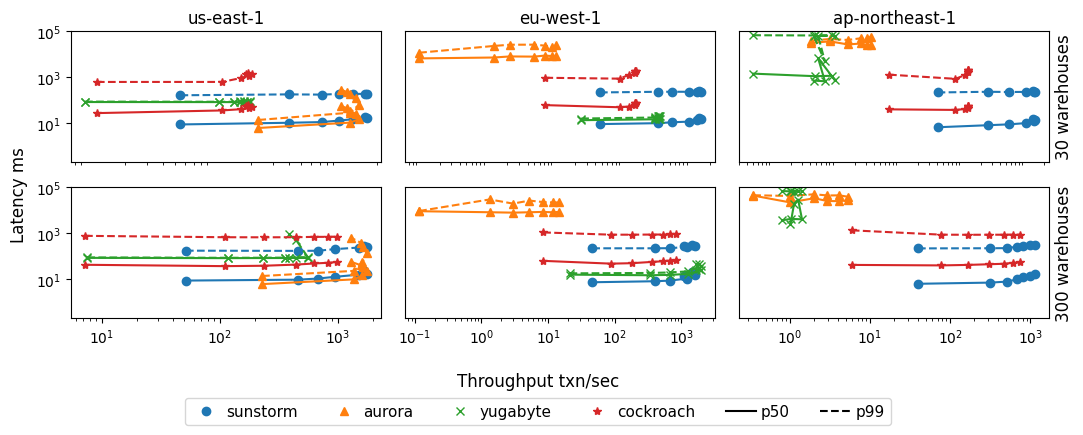

In [48]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)
fig = plt.figure(figsize=(11, 4))
gs = GridSpec(2, 3, figure=fig)

# for scalefactor in [1, 10, 100]:
for s, scalefactor in enumerate([10, 100]):
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for r, region in enumerate(["1-us-east-1-0", "2-eu-west-1-0", "3-ap-northeast-1-0"]):
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-eu-west-1-0": "eu-west-1",
            "3-ap-northeast-1-0": "ap-northeast-1",
        }[region]

        ax = plt.subplot(gs[s, r])
        legend =[]

        for i, (system, marker, color) in enumerate(zip(SYSTEMS, ["o", "^", "x", "*"], ["C0", "C1", "C2", "C3"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p99.NewOrder", "--")]:         
                system_df.plot(
                    # title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    y=y,                   
                    style=f"{marker}{linestyle}{color}",
                    rot=0,
                    logy=True,
                    logx=True,
                    #xlim=(-100, 2500),
                    ax=ax,
                )
                
                if y == "p50.NewOrder":
                    legend.append(Line2D([0], [0], lw=0, marker=marker, color=color, markerfacecolor=color, label=system))
                #legend.append(Line2D([0], [0], color=color, linestyle=linestyle, label=y)) 
                ax.get_legend().remove()
                ax.set_xlabel("")

                if r != 0:
                    ax.set_yticks([])
                if s == 0:
                    ax.set_xticks([])
                    ax.set_title(region_name)
                if r == 2:
                    ax.set_ylabel(f"{scalefactor*3} warehouses")
                    ax.yaxis.set_label_position("right")

        ax.set_ylim(bottom=0.2, top=100000)

# ax.set_ylabel("latency (ms)")
fig.supylabel("Latency ms", y=0.5)
fig.supxlabel("Throughput txn/sec", x=0.5)
# fig.suptitle("TPC-C NewOrder Transaction")

# handles=[
#     Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
#     Line2D([0], [0], color='k', linestyle='-', label='p50'),
#     Line2D([0], [0], lw=0, marker='+', color='C0', markerfacecolor='C0', label='sunstorm-serializable'),
#     Line2D([0], [0], color='k', linestyle='--', label='p99'),
#     Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
#     Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),]

legend.append(Line2D([0], [0],color='k', linestyle='-', label='p50'))
legend.append(Line2D([0], [0], color='k', linestyle='--', label='p99'))
        
fig.legend(handles=legend, 
           title="",
           ncol=6,
           loc="upper center",
           handletextpad=0.3,
           bbox_to_anchor=(0.5,0.01)  # Adjust legend position if needed
          )
plt.tight_layout()
fig.savefig("tpcc-logx.pdf", bbox_inches='tight')

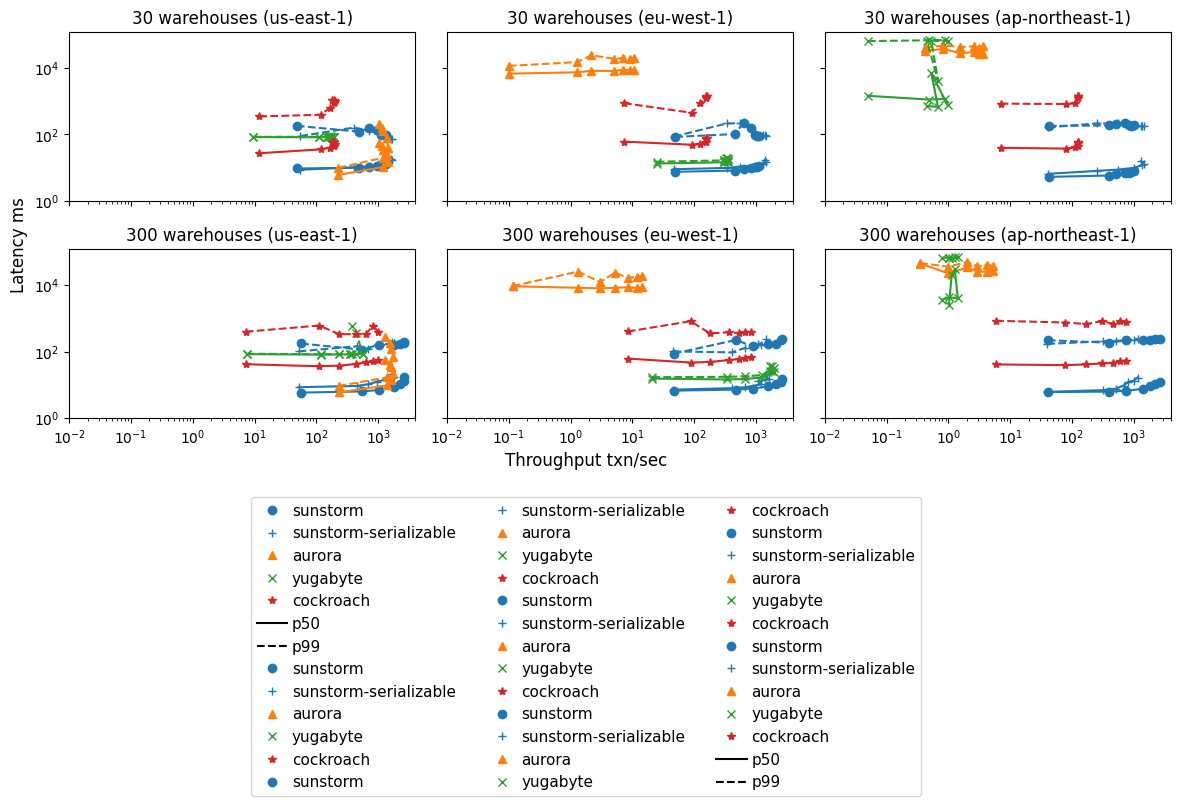

In [9]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

plt.rc('axes', labelsize=11) 
plt.rc('legend', fontsize=11)
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 3, figure=fig)

# for scalefactor in [1, 10, 100]:
for s, scalefactor in enumerate([10, 100]):
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for r, region in enumerate(["1-us-east-1-0", "2-eu-west-1-0", "3-ap-northeast-1-0"]):
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-eu-west-1-0": "eu-west-1",
            "3-ap-northeast-1-0": "ap-northeast-1",
        }[region]

        ax = plt.subplot(gs[s, r])
        for i, (system, marker, color) in enumerate(zip(SYSTEMS, ["o", "+", "^", "x", "*"], ["C0", "C0", "C1", "C2", "C3"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p95.NewOrder", "--")]:               
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    y=y,                   
                    style=f"{marker}{linestyle}{color}",
                    rot=0,
                    logy=True,
                    logx=True,
                    xlim=(0.01, 4000),
                    ylim=(1, 120000),
                    ax=ax,
                )
                if y == "p50.NewOrder":
                    legend.append(Line2D([0], [0], lw=0, marker=marker, color=color, markerfacecolor=color, label=system))
                #legend.append(Line2D([0], [0], color=color, linestyle=linestyle, label=y)) 
                ax.get_legend().remove()
                ax.set_xlabel("")


        if r != 0:
            ax.get_yaxis().set_ticklabels([])
        if s == 0:
            ax.get_xaxis().set_ticklabels([])
fig.supylabel("Latency ms", y=0.5)
fig.supxlabel("Throughput txn/sec", x=0.5, y=0.05)
#fig.suptitle("TPC-C NewOrder Transaction")
# handles=[
#     Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
#     Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
#     Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
#     Line2D([0], [0], color='k', linestyle='--', label='p99'),
#     Line2D([0], [0], color='k', linestyle='-', label='p50'),

# ]

legend.append(Line2D([0], [0],color='k', linestyle='-', label='p50'))
legend.append(Line2D([0], [0], color='k', linestyle='--', label='p99'))
        
fig.legend(handles=legend, 
           title="",
           ncol=3,
           loc="upper center",
           handletextpad=0.3,
           bbox_to_anchor=(0.5,0.01)  # Adjust legend position if needed
          )
plt.tight_layout()
fig.savefig(f"tpcc-logx.pdf", bbox_inches="tight")

# Errors


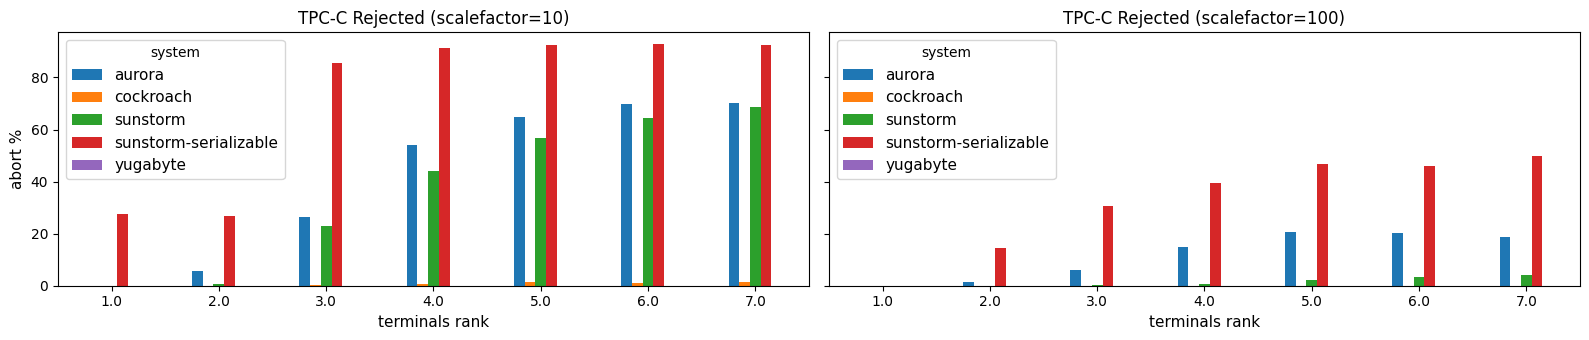

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3.5), sharex=True, sharey=True)

for i, scalefactor in enumerate([10, 100]):
    filtered = throughput_df[
        throughput_df["scalefactor"] == scalefactor
    ].sort_values("terminals_rank")
    rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values="rejected", aggfunc="sum")
    completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values="completed", aggfunc="sum")
    ratio_df = rejected_df / (rejected_df + completed_df) * 100
    ratio_df.plot.bar(
        title=f"TPC-C Rejected (scalefactor={scalefactor})",
        xlabel="terminals rank",
        ylabel="abort %",
        ax=axes[i],
        rot=0,
    )

fig.tight_layout()


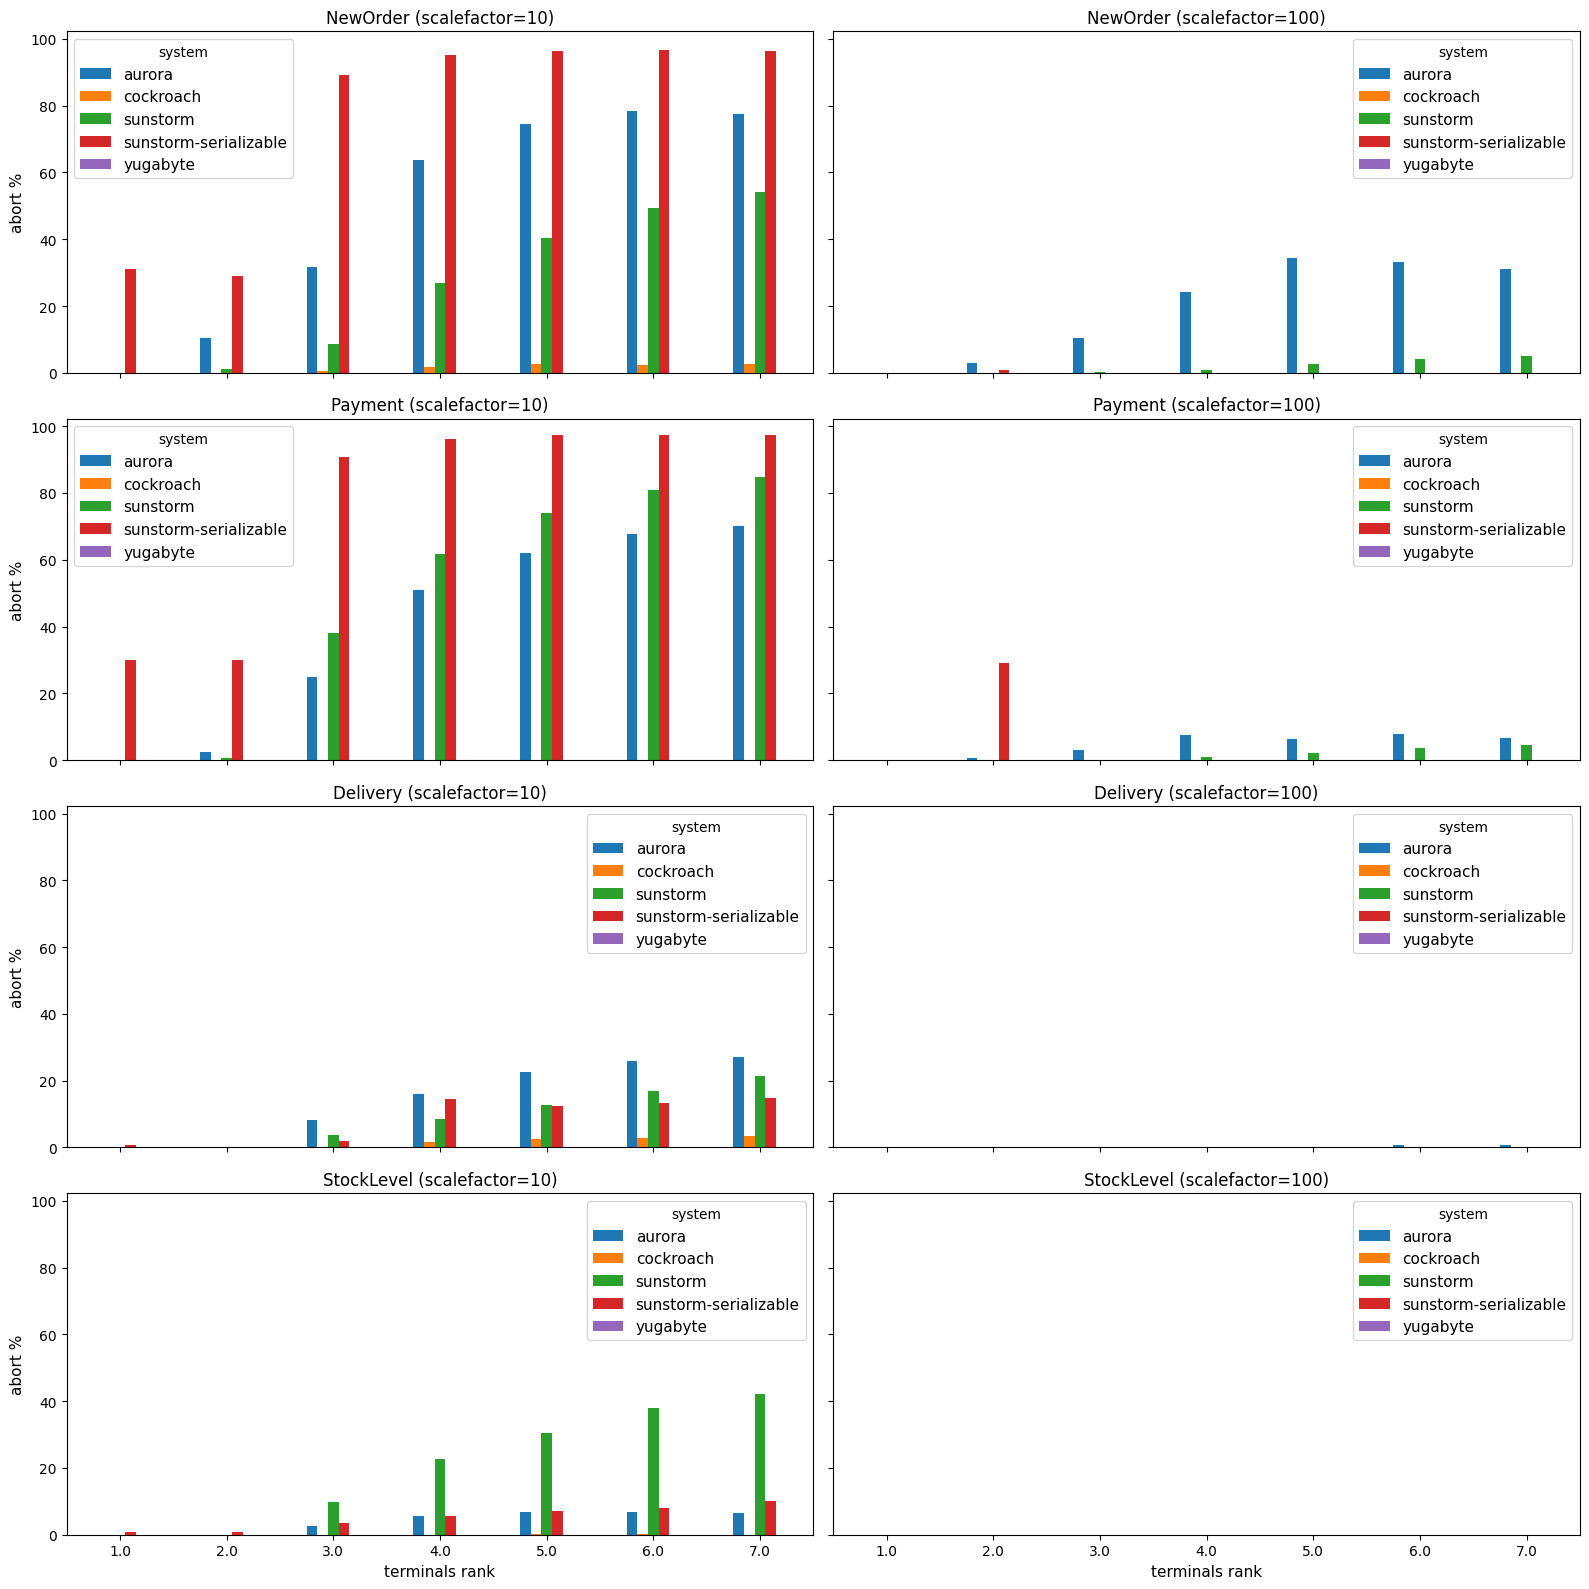

In [11]:
#transactions = ["NewOrder", "Payment", "OrderStatus", "Delivery", "StockLevel"]
transactions = ["NewOrder", "Payment", "Delivery", "StockLevel"]
fig, axes = plt.subplots(len(transactions), 2, figsize=(16, 16), sharex=True, sharey=True)

for row, transaction in enumerate(transactions):
    for col, scalefactor in enumerate([10, 100]):
        filtered = throughput_df[
            throughput_df["scalefactor"] == scalefactor
        ].sort_values("terminals_rank")
        rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"rejected.{transaction}", aggfunc="sum")
        completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"completed.{transaction}", aggfunc="sum")
        ratio_df = rejected_df / (rejected_df + completed_df) * 100
        ratio_df.plot.bar(
            title=f"{transaction} (scalefactor={scalefactor})",
            xlabel="terminals rank",
            ylabel="abort %",
            ax=axes[row, col],
            rot=0,
        )

fig.tight_layout()
